# 0. Imports

In [165]:
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [56]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Replace 'path_to_file' with the path of "Census_Data" in your Google Drive
path = '/content/drive/Shareddrives/Capstone - IBM/Data/energy_dataset.csv'  # Adjust the path and file name as needed

df_energy = pd.read_csv(path)
df_energy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [57]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

# 1. Data Cleaning

## 1.1 Energy Data

In [58]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [59]:
## Column 10: Generation Hydro Pumped Storage Aggregated and Column 23: forecast wind offshore eday ahead are completely empty and will therefore be ommitted
## Generation levels for fossil oil shale, fossil peat, generation geothermal and wind off shore are zero at all times --> drop
## Generation levels for coal dervied gas and generation marin are 0 at all times --> drop

In [60]:
df_energy.drop(["generation hydro pumped storage aggregated","generation fossil coal-derived gas","generation marine","forecast wind offshore eday ahead", "generation fossil oil shale","generation fossil peat","generation geothermal","generation wind offshore"], axis=1, inplace=True)
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35045 non-null  float64
 1   generation fossil brown coal/lignite         35046 non-null  float64
 2   generation fossil gas                        35046 non-null  float64
 3   generation fossil hard coal                  35046 non-null  float64
 4   generation fossil oil                        35045 non-null  float64
 5   generation hydro pumped storage consumption  35045 non-null  float64
 6   generation hydro run-of-river and poundage   35045 non-null  float64
 7   generation hydro water reservoir             35046 non-null  float64
 8   generation nuclear                           35047 non-null  float64
 9   generation other         

### 1.1.1 Null Values

In [61]:
# Filter the DataFrame for rows with null values in any column
null_rows = df_energy[df_energy.isnull().any(axis=1)]
null_rows

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,
2015-01-05 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,546.0,8233.0,21912.0,21182.0,35.20,59.68
2015-01-05 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3932.0,9258.0,23209.0,NaN,35.50,79.14
2015-01-05 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4236.0,9156.0,23725.0,NaN,36.80,73.95
2015-01-05 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4215.0,9072.0,23614.0,NaN,32.50,71.93
2015-01-05 14:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4050.0,8779.0,22381.0,NaN,30.00,71.50
2015-01-05 15:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3728.0,8426.0,21371.0,NaN,30.00,71.85
2015-01-05 16:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3175.0,7946.0,20760.0,NaN,30.60,80.53
2015-01-19 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,6434.0,38642.0,39304.0,70.01,88.95
2015-01-19 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,6907.0,38758.0,39262.0,69.00,87.94


In [62]:
## In total there are 47 instances where we are missing some or almost all data. Do we drop values or fill with rolling average?

In [63]:
# Fill missing values with backfill option, which fills the missing value with the next valid value it finds moving forward in the DataFrame. If the next valid value is found within the specified limit, it will be used; otherwise, the missing value remains.
df_energy = df_energy.fillna(value=None, method='backfill', axis=0, limit=8, downcast=None)

In [64]:
# Filter the DataFrame for rows with null values in any column --> there are none left
null_rows = df_energy[df_energy.isnull().any(axis=1)]
null_rows

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,


In [65]:
df_energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.529888,448.097222,5622.695642,4256.511921,298.343515,475.601415,972.197467,2605.572125,6263.465007,60.226643,85.634326,1432.832136,269.418178,5464.845311,1439.066735,5471.216689,28712.129962,28698.954198,49.874341,57.884023
std,85.346201,354.620143,2201.483995,1962.005905,52.521901,792.344571,400.712038,1835.349203,840.302056,20.238834,14.077016,1679.946586,50.219732,3213.474657,1677.703355,3176.312853,4594.100854,4576.561310,14.618900,14.204083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1078.000000,5759.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,69.000000,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,4969.000000,4475.000000,300.000000,68.000000,906.000000,2164.000000,6564.000000,57.000000,88.000000,616.000000,279.000000,4849.500000,576.000000,4855.000000,28906.000000,28904.000000,50.520000,58.020000
75%,433.000000,757.000000,6429.000000,5839.000000,330.000000,616.000000,1250.000000,3758.000000,7025.000000,80.000000,97.000000,2579.000000,310.000000,7401.000000,2636.000000,7353.000000,32263.250000,32195.000000,60.530000,68.010000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,5836.000000,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [66]:
# Cehck for duplicates
dup_energy = df_energy.duplicated(keep='first').sum()
print('There are {} duplicate rows in df_energy based on all columns.'
      .format(dup_energy))

There are 0 duplicate rows in df_energy based on all columns.


In [67]:
import matplotlib as plt

### 1.1.2 Visualizations & Outliers

In [80]:
# Visualize Fossil fuel generation over time
traces = []
trace_names = df_energy.columns[1:5]

# Loop through each index return column
for series, name in zip(df_energy.columns[1:5], trace_names):
    trace = go.Scatter(x=df_energy.index, y=df_energy[series], mode='lines', name=name)
    traces.append(trace)


# Create Figure & Update as needed
fig = go.Figure(data=traces)
fig.update_layout(
    title='Fossil fuel generation over Time',
    xaxis_title='Time',
    yaxis_title='Generation Amount',
    width=1000,
    height=500)

fig.update_xaxes(showgrid=False)  # Ensure x-axis grid is off

# Show plot
fig.show()


Output hidden; open in https://colab.research.google.com to view.

In [69]:
## Chart is interactive, click on map on the right to choose which time series you want to visualize

In [70]:
## Observations:
### Gas is by far the largest and quite volatile but in a seasonal way, notably there is only one key outlier, where generation is at 0 --> fix
### Brown Coal is super volatile and often at 0 and in general pretty low --> leave as is
### Hard Coal similar to Gas, one key outlier where generation is at 0 --> fix
### Oil is minisicule, stable with a few outliers --> smooth with 2 std. dev barrier



In [95]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

In [97]:
# Visualize Renewables generation over time
traces = []
column_indices = [0] + list(range(5, 8)) + list(range(10,14))
trace_names = df_energy.columns[column_indices]


# Loop through each index return column
for series, name in zip(df_energy.columns[column_indices], trace_names):
    trace = go.Scatter(x=df_energy.index, y=df_energy[series], mode='lines', name=name)
    traces.append(trace)


# Create Figure & Update as needed
fig = go.Figure(data=traces)
fig.update_layout(
    title='Renewables generation over Time',
    xaxis_title='Time',
    yaxis_title='Generation Amount',
    width=1000,
    height=500)

fig.update_xaxes(showgrid=False)  # Ensure x-axis grid is off

# Show plot
fig.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## Observations:
### Biomass quite volatile but with seasonality. There are three key outliers to be removed: 2 when it falls to 0 and 1 when it falls down to 101
### Hydro river shows strong seasonality (annual) but also intra day --> sfix 0 value and leave unchanged
### Hydro storage has huge volatility intraday and also annual --> leave unchanged
### Solar is massive with huge volatlity as it can only be generated during the day and seasons highly affect output
### Waste is volatile --> smooth with 2 std. dev barrier
### Other renewable is minisicule, stable with a few outliers --> smooth with 2 std. dev barrier

In [102]:
# Visualize Other Sources generation over time
traces = []
trace_names = df_energy.columns[8:10]


# Loop through each index return column
for series, name in zip(df_energy.columns[8:10], trace_names):
    trace = go.Scatter(x=df_energy.index, y=df_energy[series], mode='lines', name=name)
    traces.append(trace)


# Create Figure & Update as needed
fig = go.Figure(data=traces)
fig.update_layout(
    title='Other Sources generation over Time',
    xaxis_title='Time',
    yaxis_title='Generation Amount',
    width=1000,
    height=500)

fig.update_xaxes(showgrid=False)  # Ensure x-axis grid is off

# Show plot
fig.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## Observations:
### Generation from nuclear is among the largest and relative constant --> smooth with 2 Std Dev
### Generation other is miniscule --> smooth with 2 std dev barrier

In [107]:
# Visualize Forecasted generation over time
traces = []
trace_names = df_energy.columns[14:16]


# Loop through each index return column
for series, name in zip(df_energy.columns[14:16], trace_names):
    trace = go.Scatter(x=df_energy.index, y=df_energy[series], mode='lines', name=name)
    traces.append(trace)


# Create Figure & Update as needed
fig = go.Figure(data=traces)
fig.update_layout(
    title='Forecasted generation over Time',
    xaxis_title='Time',
    yaxis_title='Generation Amount',
    width=1000,
    height=500)

fig.update_xaxes(showgrid=False)  # Ensure x-axis grid is off

# Show plot
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [104]:
# No cleaning needed

In [106]:
# Visualize Forecasted generation over time
traces = []
trace_names = df_energy.columns[16:]


# Loop through each index return column
for series, name in zip(df_energy.columns[16:], trace_names):
    trace = go.Scatter(x=df_energy.index, y=df_energy[series], mode='lines', name=name)
    traces.append(trace)


# Create Figure & Update as needed
fig = go.Figure(data=traces)
fig.update_layout(
    title='Forecasted generation over Time',
    xaxis_title='Time',
    yaxis_title='Generation Amount',
    width=1000,
    height=500)

fig.update_xaxes(showgrid=False)  # Ensure x-axis grid is off

# Show plot
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [108]:
# total Load Forecast and Actual do not need any cleaning

In [109]:
# Price day ahead and price actual show significant differences

In [ ]:
# Price Actual has numerous outliers and should be smoothed

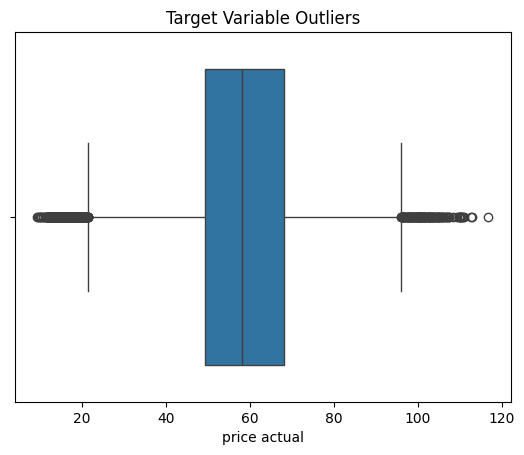

In [114]:
ax =sns.boxplot(x=df_energy['price actual'],)
ax.set_title('Target Variable Outliers')
plt.show()

#### 1.1.2.1 Fixing Individual Outliers

In [71]:
# Fix zero value for Gas with average value of 3 hours prior
timestamp = "2018-06-02 09:00:00+00:00"
specific_index = df_energy.index.get_loc(timestamp)

# Calculate the average of the 3 values prior to the specified timestamp
average_value = df_energy["generation fossil gas"].iloc[specific_index-3:specific_index].mean()

# Set the value of the specified cell to this average
df_energy.at[timestamp, "generation fossil gas"] = average_value


In [72]:
# Fix zero values for hard coal with average value of 3 hours prior
zeros_hard_coal = df_energy[df_energy["generation fossil hard coal"]==0]
for i in zeros_hard_coal.index:
  timestamp = i
  specific_index = df_energy.index.get_loc(timestamp)
  average_value = df_energy["generation fossil hard coal"].iloc[specific_index-3:specific_index].mean()
  df_energy.at[timestamp, "generation fossil hard coal"] = average_value



In [87]:
# Biomass
outliers_biomass = df_energy[df_energy["generation biomass"]==0]
for i in outliers_biomass.index:
  timestamp = i
  specific_index = df_energy.index.get_loc(timestamp)
  average_value = df_energy["generation biomass"].iloc[specific_index-3:specific_index].mean()
  df_energy.at[timestamp, "generation biomass"] = average_value


In [92]:
# generation hydro run-of-river and poundage
outliers_runof = df_energy[df_energy["generation hydro run-of-river and poundage"]==0]
for i in outliers_biomass.index:
  timestamp = i
  specific_index = df_energy.index.get_loc(timestamp)
  average_value = df_energy["generation hydro run-of-river and poundage"].iloc[specific_index-3:specific_index].mean()
  df_energy.at[timestamp, "generation hydro run-of-river and poundage"] = average_value

#### 1.1.2.2 Smoohting Outliers via Std Dev Barrier

In [73]:
def std_dev_cleaner(df, column_name):
    # Calculate the mean and standard deviation of the specified column
    mean = df[column_name].mean()
    std_dev = df[column_name].std()

    # Calculate the upper and lower boundary (2 standard deviations from the mean)
    lower_boundary = mean - 2 * std_dev
    upper_boundary = mean + 2 * std_dev

    # Replace values outside the boundaries with the nearest boundary value
    df[column_name] = df[column_name].apply(lambda x: max(min(x, upper_boundary), lower_boundary))

    return df


In [74]:
# Fossil Oil
df_energy = std_dev_cleaner(df_energy, "generation fossil oil")

In [89]:
# Waste
df_energy = std_dev_cleaner(df_energy, "generation waste")

In [96]:
df_energy = std_dev_cleaner(df_energy, "generation other renewable")

In [99]:
df_energy = std_dev_cleaner(df_energy, "generation nuclear")

In [101]:
df_energy = std_dev_cleaner(df_energy, "generation other")

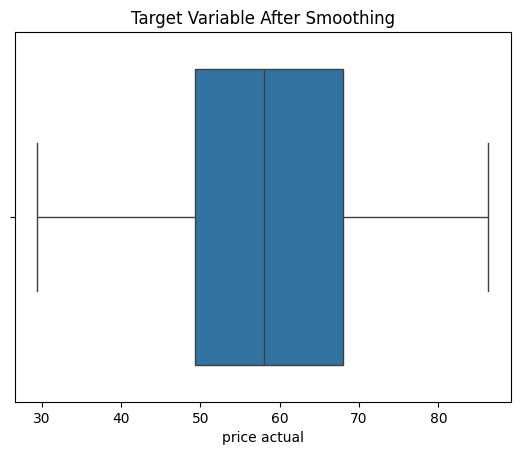

In [115]:
# Target Variable
df_energy = std_dev_cleaner(df_energy, "price actual")

ax =sns.boxplot(x=df_energy['price actual'],)
ax.set_title('Target Variable After Smoothing')
plt.show()


### 1.1.3 Correlations

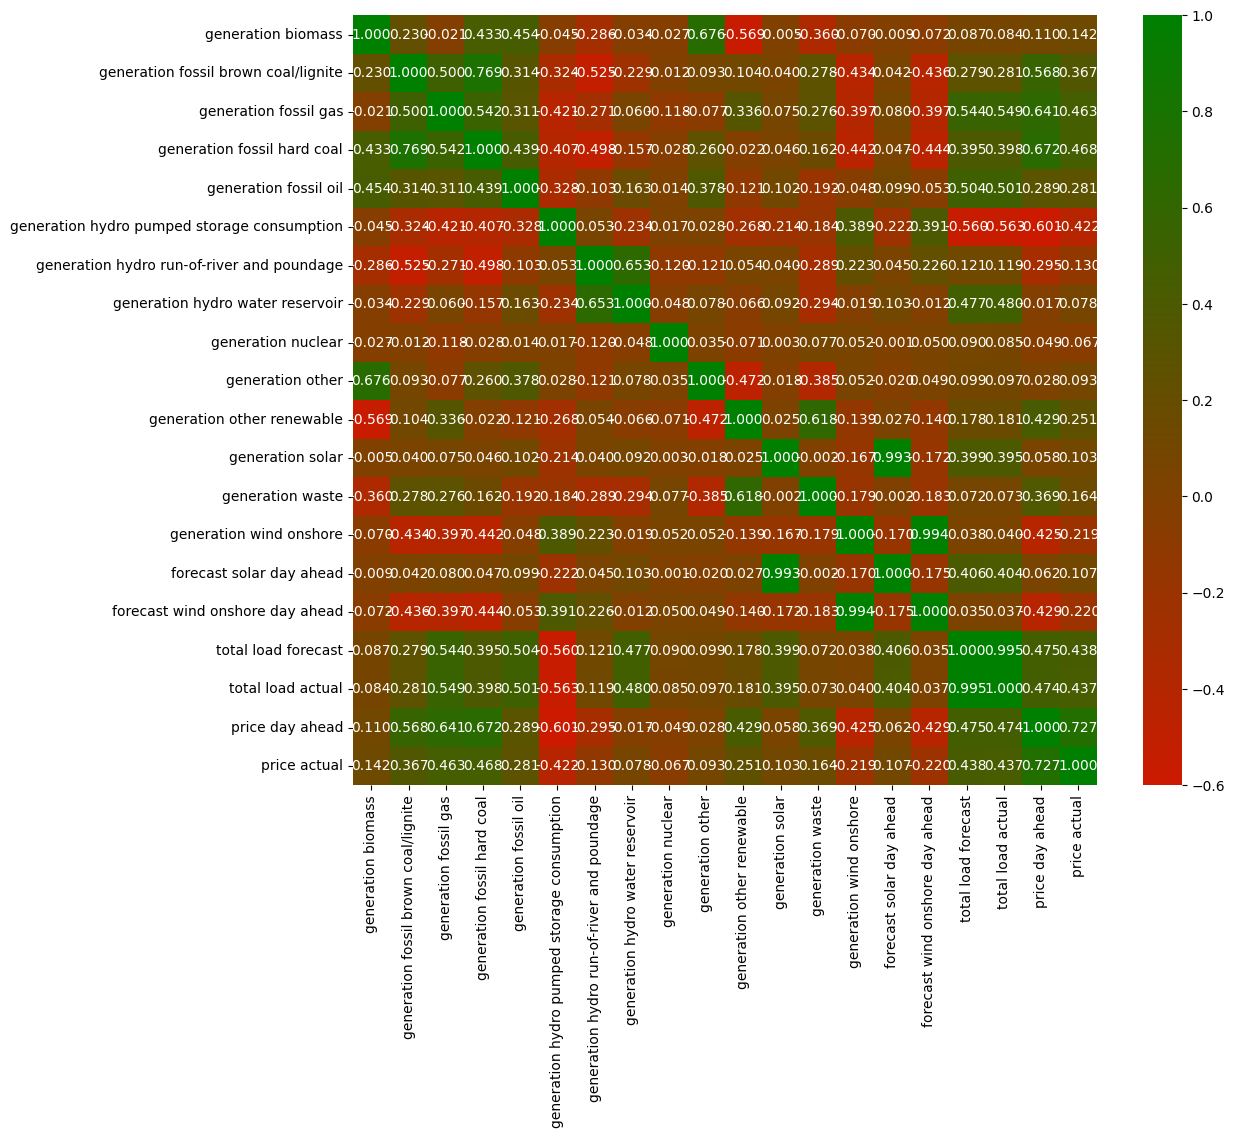

In [117]:
# Explore correlations between columns
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
corr_data = df_energy.corr()
plt.figure(figsize=(12, 10))
cmap = LinearSegmentedColormap.from_list('rg', ["red", "green"], N=256)
sns.heatmap(corr_data, annot=True,cmap=cmap, center=0, fmt=".3f")
plt.show()

## 1.2 Weather Data

In [118]:
path = '/content/drive/Shareddrives/Capstone - IBM/Data/weather_features.csv'

df_weather = pd.read_csv(path)
df_weather

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [119]:
# Convert time to datetime object and set it as index
df_weather.rename(columns={'dt_iso': 'time'}, inplace=True)
df_weather['time'] = pd.to_datetime(df_weather['time'], utc=True, infer_datetime_format=True)
df_weather = df_weather.set_index('time')

In [120]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   city_name            178396 non-null  object 
 1   temp                 178396 non-null  float64
 2   temp_min             178396 non-null  float64
 3   temp_max             178396 non-null  float64
 4   pressure             178396 non-null  int64  
 5   humidity             178396 non-null  int64  
 6   wind_speed           178396 non-null  int64  
 7   wind_deg             178396 non-null  int64  
 8   rain_1h              178396 non-null  float64
 9   rain_3h              178396 non-null  float64
 10  snow_3h              178396 non-null  float64
 11  clouds_all           178396 non-null  int64  
 12  weather_id           178396 non-null  int64  
 13  weather_main         178396 non-null  object 
 14  weather_description  1

In [121]:
df_weather.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


Here, we can see that all columns of df_weather have the same number of rows; we still have to check what is the case for each city individually, though. We should note that the temperatures are in Kelvin. The most important thing to notice is that there are some problems and outliers. In particular:

- There is at least one outlier in the 'pressure' column as the maximum value is 1,008,371 hPa or approximately 100 MPa, which is roughly the pressure at the bottom of Mariana Trench about 11 km below ocean surface [1](https://en.wikipedia.org/wiki/Orders_of_magnitude_(pressure). This cannot be the case here.
- There is at least one outlier in the 'wind_speed' column as the maximum value is 133 m/s. This measurement is close to the fastest wind speed ever recorded on Earth, caused by the 1999 Bridge Creek–Moore tornado [2](https://en.wikipedia.org/wiki/Orders_of_magnitude_(speed), a F5 (the largest intensity of the Fujita scale) tornado [3](https://en.wikipedia.org/wiki/Fujita_scale). A tornado of such intensity has not been recorded in Spain [4](https://en.wikipedia.org/wiki/List_of_European_tornadoes_and_tornado_outbreaks) and hopefully will not happen in the future as well.
- The 'rain_3h' column is supposed to provide information about the precipitation (i.e. rain) of the last 3 hours in mm. Since the 'rain_1h' column is supposed to provide the same information but about just the last hour, it would be logical to assume that its mean would be less than that of 'rain_3h'. However, this is not the case in the statistical description above. So, it would be a good idea to further examine those columns.


### 1.2.1 Data Conversion

In [122]:
# Convert Kelvin temperature columns to Celcius

kelvin_columns = df_weather.columns[1:4]

for i in kelvin_columns:
  df_weather[i] = round(df_weather[i] - 273.15, 3)


In [123]:
# Convert columns with int64 type values to float64 type

def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df


df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

### 1.2.2 Null Values & Duplicates

In [124]:
# Display average weather features grouped by each city

mean_weather_by_city = df_weather.groupby('city_name').mean()
mean_weather_by_city

<ipython-input-124-0da3d649e15e>:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,16.698255,15.444711,17.871995,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,13.228500,11.766673,14.886699,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,14.911077,13.674883,16.005606,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,19.955437,18.034110,22.812438,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,17.630787,17.072284,18.205032,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [125]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.


In [126]:
print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


Note that we do not have the same number of observations per city and none of them match with the number of observations we have for energy prices!

--> We must clean the weather data before being able to merge it with the energy dataframe

In [127]:
# Keep only the first observation where index and city are the same, remove all other duplicates
df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [128]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [129]:
# Check number of NaNs
dup_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'],
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(dup_weather))


There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


We successfully cleaned the datset so that there are now the exact same number of rows per city as there are observations for the energy dataframe

The weather_icon' is irrelevant for our analysis, so it should be dropped. Furthermore, the columns 'weather_main' and 'weather_description' contain approximately the same information as the column 'weather_id'; however, they are also the reason we have duplicates. Therefore, these columns will be dropeed

In [130]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id', 'weather_description', 'weather_icon'], axis=1)

### 1.2.3 Visualizations & Outliers

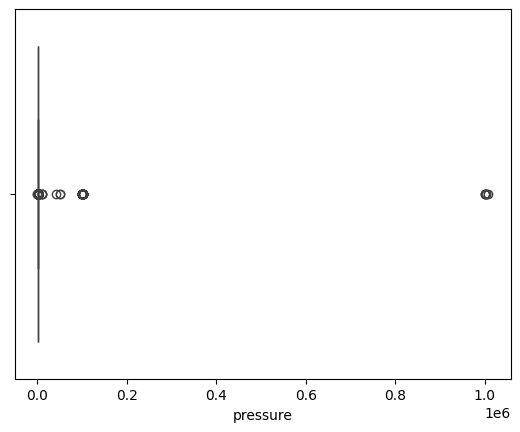

In [131]:
# Clean outliers in Pressure column
sns.boxplot(x=df_weather['pressure'])
plt.show()

We clearly observe an outlier at the 1,000,000 level.  To clean any outliers, any values in the 'pressure' column which are higher than 1051 hPa, which is just above the highest air pressure ever recorded in the Iberian peninsula [6](https://en.wikipedia.org/wiki/List_of_atmospheric_pressure_records_in_Europe#Iberia), will be set to NaN. While outliers on the low side are not discernable in the graph above, any values lower than 931 hPa, the lowest air pressure ever recorded in the Iberian peninsula, will also be set to NaN.

In [132]:
# Replace outliers in 'pressure' with NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

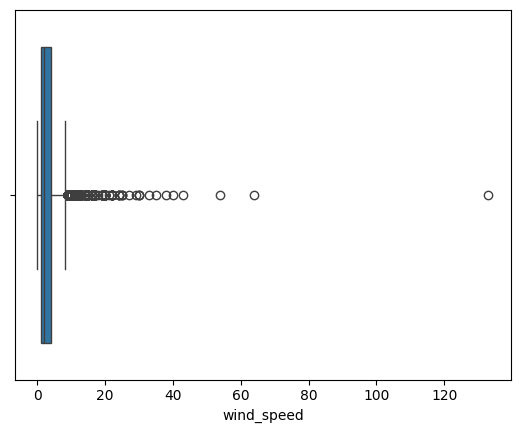

In [133]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

Here too we observe a number of outliers, keeping in mind that the metric is m/s. Any value above 50 m/s, the highest wind speed ever measures in Spain [4](https://en.wikipedia.org/wiki/List_of_European_tornadoes_and_tornado_outbreaks) will be set to NaN.

In [134]:

## move to github

In [135]:
# Replace outliers in 'wind_speed' with NaNs

df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

In [136]:
# Fill missing values with backfill option, which fills the missing value with the next valid value it finds moving forward in the DataFrame. If the next valid value is found within the specified limit, it will be used; otherwise, the missing value remains.
df_weather = df_weather.fillna(value=None, method='backfill', axis=0, limit=10000, downcast=None)

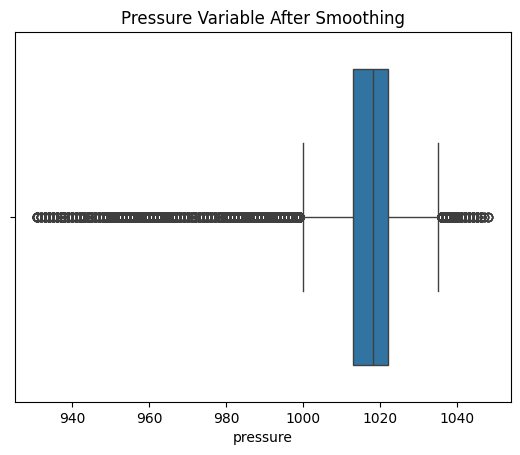

In [138]:
# Show box plots post cleaning
ax =sns.boxplot(x=df_weather['pressure'])
ax.set_title('Pressure Variable After Smoothing')
plt.show()

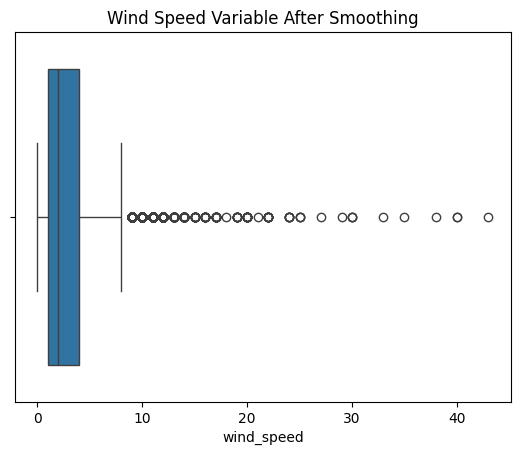

In [139]:
ax =sns.boxplot(x=df_weather['wind_speed'])
ax.set_title('Wind Speed Variable After Smoothing')
plt.show()

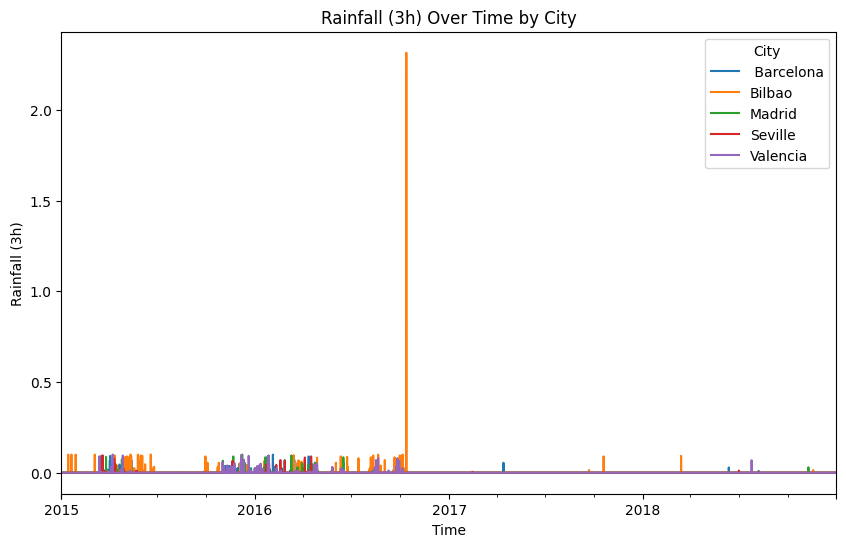

In [140]:
df_pivoted = df_weather.pivot(columns='city_name', values='rain_3h')

# Plot the data
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
df_pivoted.plot(kind='line', ax=plt.gca())
plt.title('Rainfall (3h) Over Time by City')
plt.xlabel('Time')
plt.ylabel('Rainfall (3h)')
plt.legend(title='City')
plt.show()

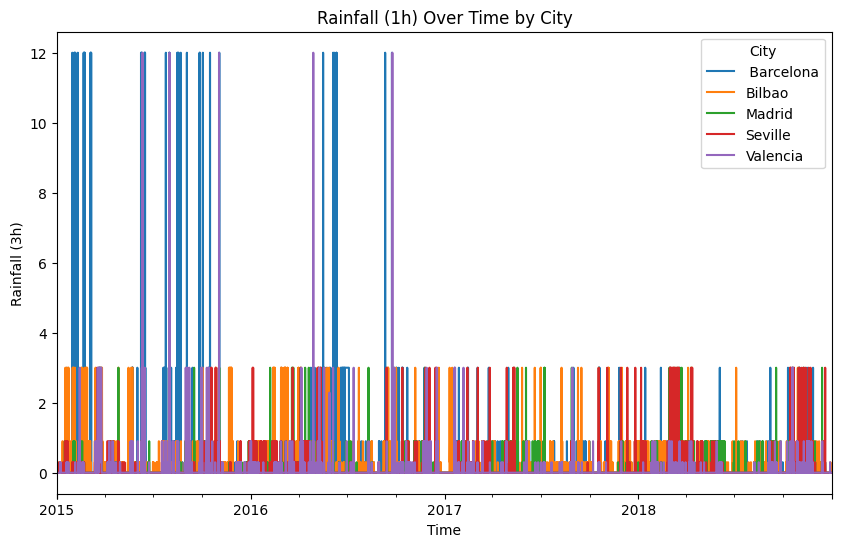

In [141]:
df_pivoted = df_weather.pivot(columns='city_name', values='rain_1h')

# Plot the data
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
df_pivoted.plot(kind='line', ax=plt.gca())
plt.title('Rainfall (1h) Over Time by City')
plt.xlabel('Time')
plt.ylabel('Rainfall (3h)')
plt.legend(title='City')
plt.show()

We conclude that the 3h variable is useless as it simply does not add up with the 1h column, therefore, this column will be dropped

In [142]:
df_weather.drop(["rain_3h"], axis=1, inplace=True)

# 2. Combined Data Set

In [143]:
# Split the df_weather into 5 dataframes (one for each city)
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [144]:
df_complete = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_complete = df_complete.merge(df, on=['time'], how='outer')
    df_complete = df_complete.drop('city_name_{}'.format(city_str), axis=1)

df_complete.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp_Barcelona', 'temp_min_Barcelona',
       'temp_max_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona',
       'wind_speed_Barcelona', 'wind_deg_Barcelona', 'rain_1h_Barcelona',
       'snow_3h_Barcelona', 'clouds_all_Barcelona', 'temp_Bilbao',
       'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bi

In [145]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_complete.isnull().values.sum()))

dup_complete = df_complete.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(dup_complete))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


## 2.1 Feature Engineering

In [156]:
# create hour/weekday/ month column

In [157]:
for i in range(len(df_complete)):
    position = df_complete.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_complete.loc[position, 'hour'] = hour
    df_complete.loc[position, 'weekday'] = weekday
    df_complete.loc[position, 'month'] = month

In [158]:
# Generate 'business hour' feature
for i in range(len(df_complete)):
    position = df_complete.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_complete.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_complete.loc[position, 'business hour'] = 1
    else:
        df_complete.loc[position, 'business hour'] = 0

In [159]:
# Generate 'weekend' feature

for i in range(len(df_complete)):
    position = df_complete.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_complete.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_complete.loc[position, 'weekday'] = 1
    else:
        df_complete.loc[position, 'weekday'] = 0

In [152]:
# Create seasons
condition_winter = (df_complete.index.month>=1)&(df_complete.index.month<=3)
condtion_spring = (df_complete.index.month>=4)&(df_complete.index.month<=6)
condition_summer = (df_complete.index.month>=7)&(df_complete.index.month<=9)
condition_automn = (df_complete.index.month>=10)@(df_complete.index.month<=12)

# Create column in dataframe that inputs the season based on the conditions created above
df_complete['season'] = np.where(condition_winter,'winter',
                            np.where(condtion_spring,'spring',
                                     np.where(condition_summer,'summer',
                                              np.where(condition_automn,'fall',np.nan))))

In [22]:
# Add column to generate delta between Actual and Forecasted Load
df_energy["load_delta"] = df_energy["total load actual"]- df_energy["total load forecast"]

In [160]:
# Add column to generate delta between Actual and Predicted Price
df_energy["price_delta"] = df_energy["price actual"]- df_energy["price day ahead"]

In [ ]:
# create holiday column with function

In [161]:
# Combine Coal columns into one due to high correlation
df_complete['generation coal all'] = df_complete['generation fossil hard coal'] + df_complete['generation fossil brown coal/lignite']

## 2.2 Seasonality Analysis

In [146]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

<ipython-input-146-a7542a908183>:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



### 2.1.1 Weekly Rolling Mean

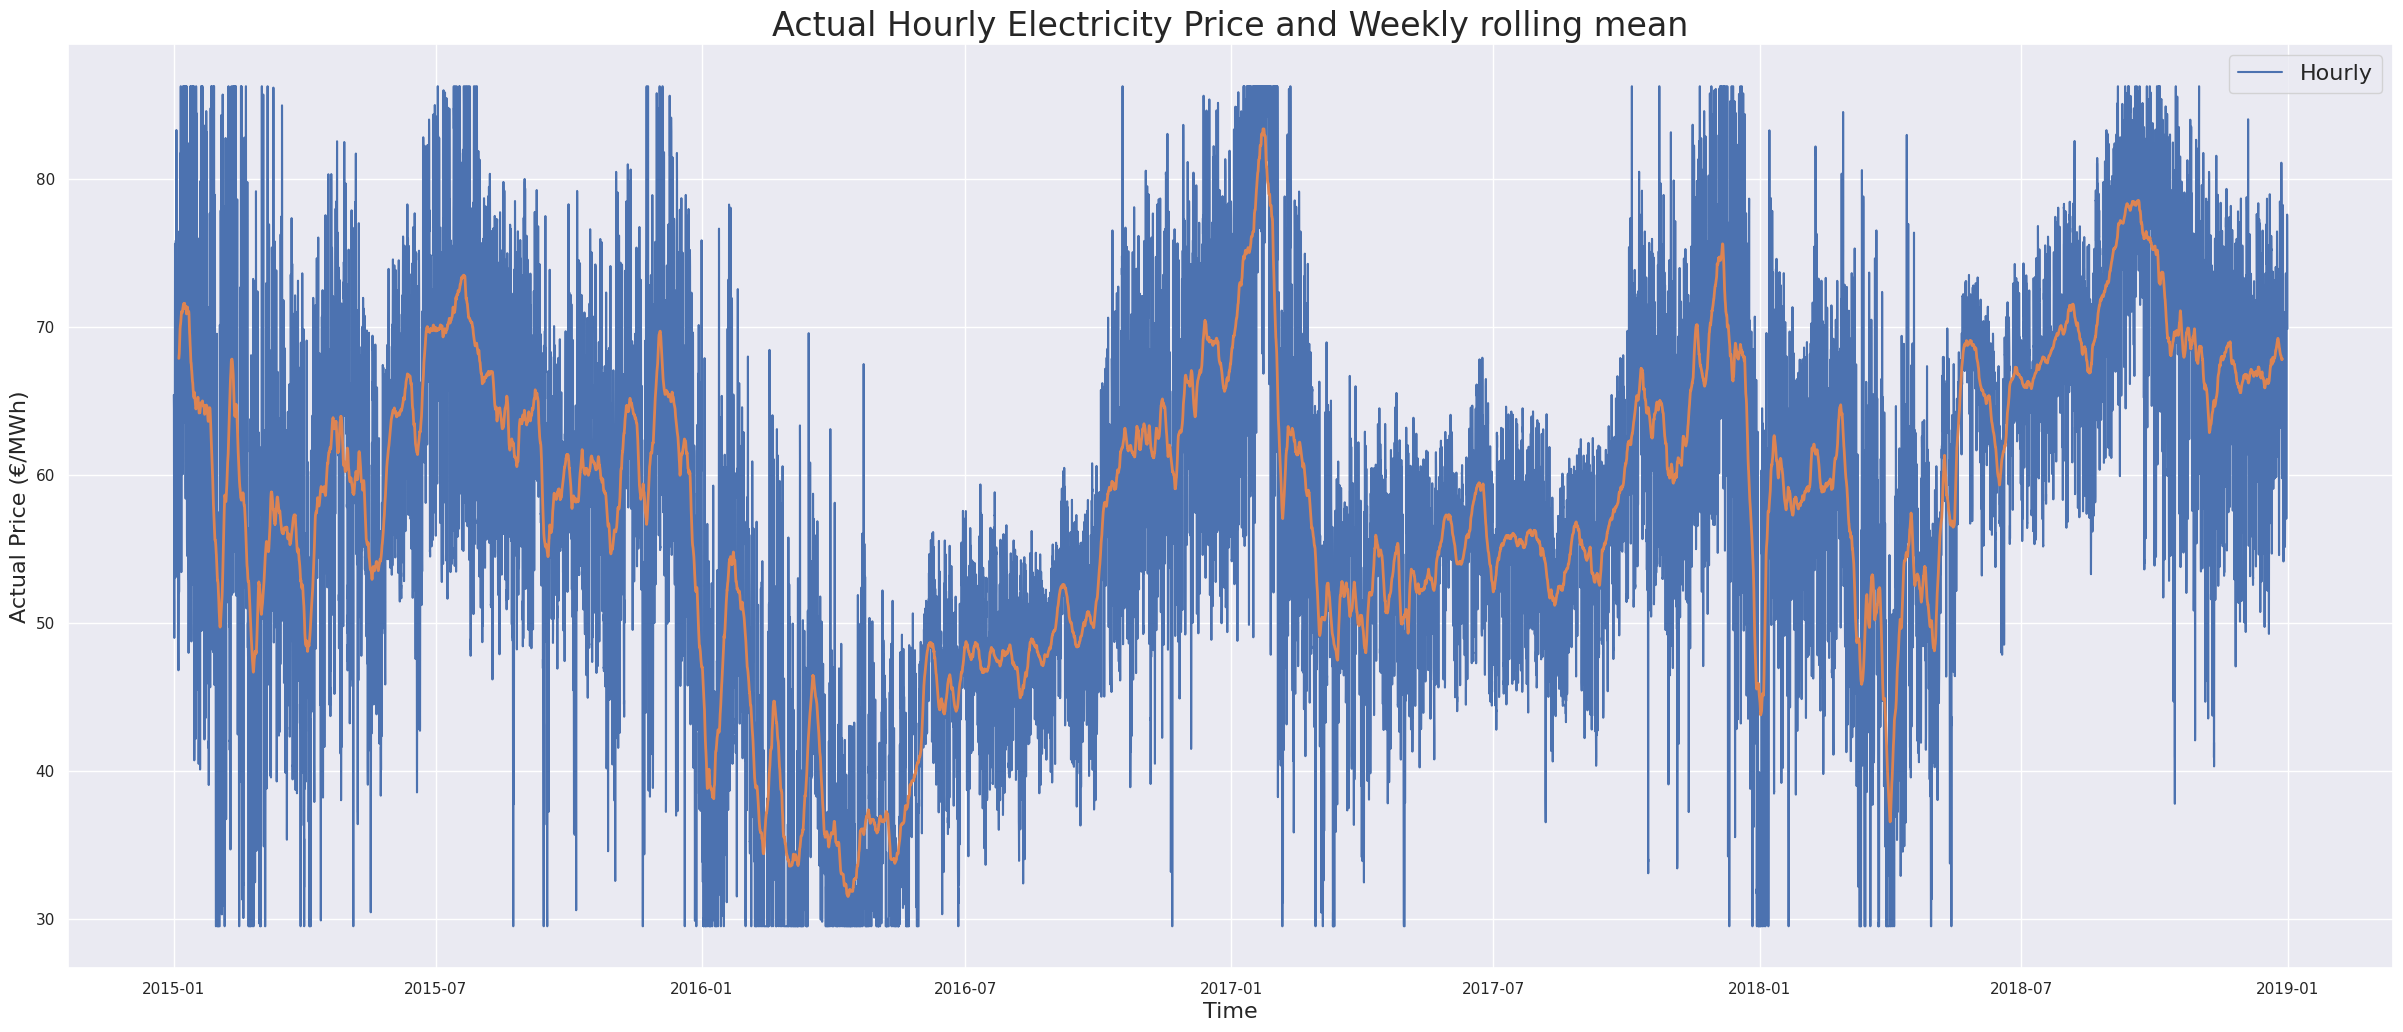

In [147]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_complete['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_complete, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

### 2.1.2 Hourly Patterns

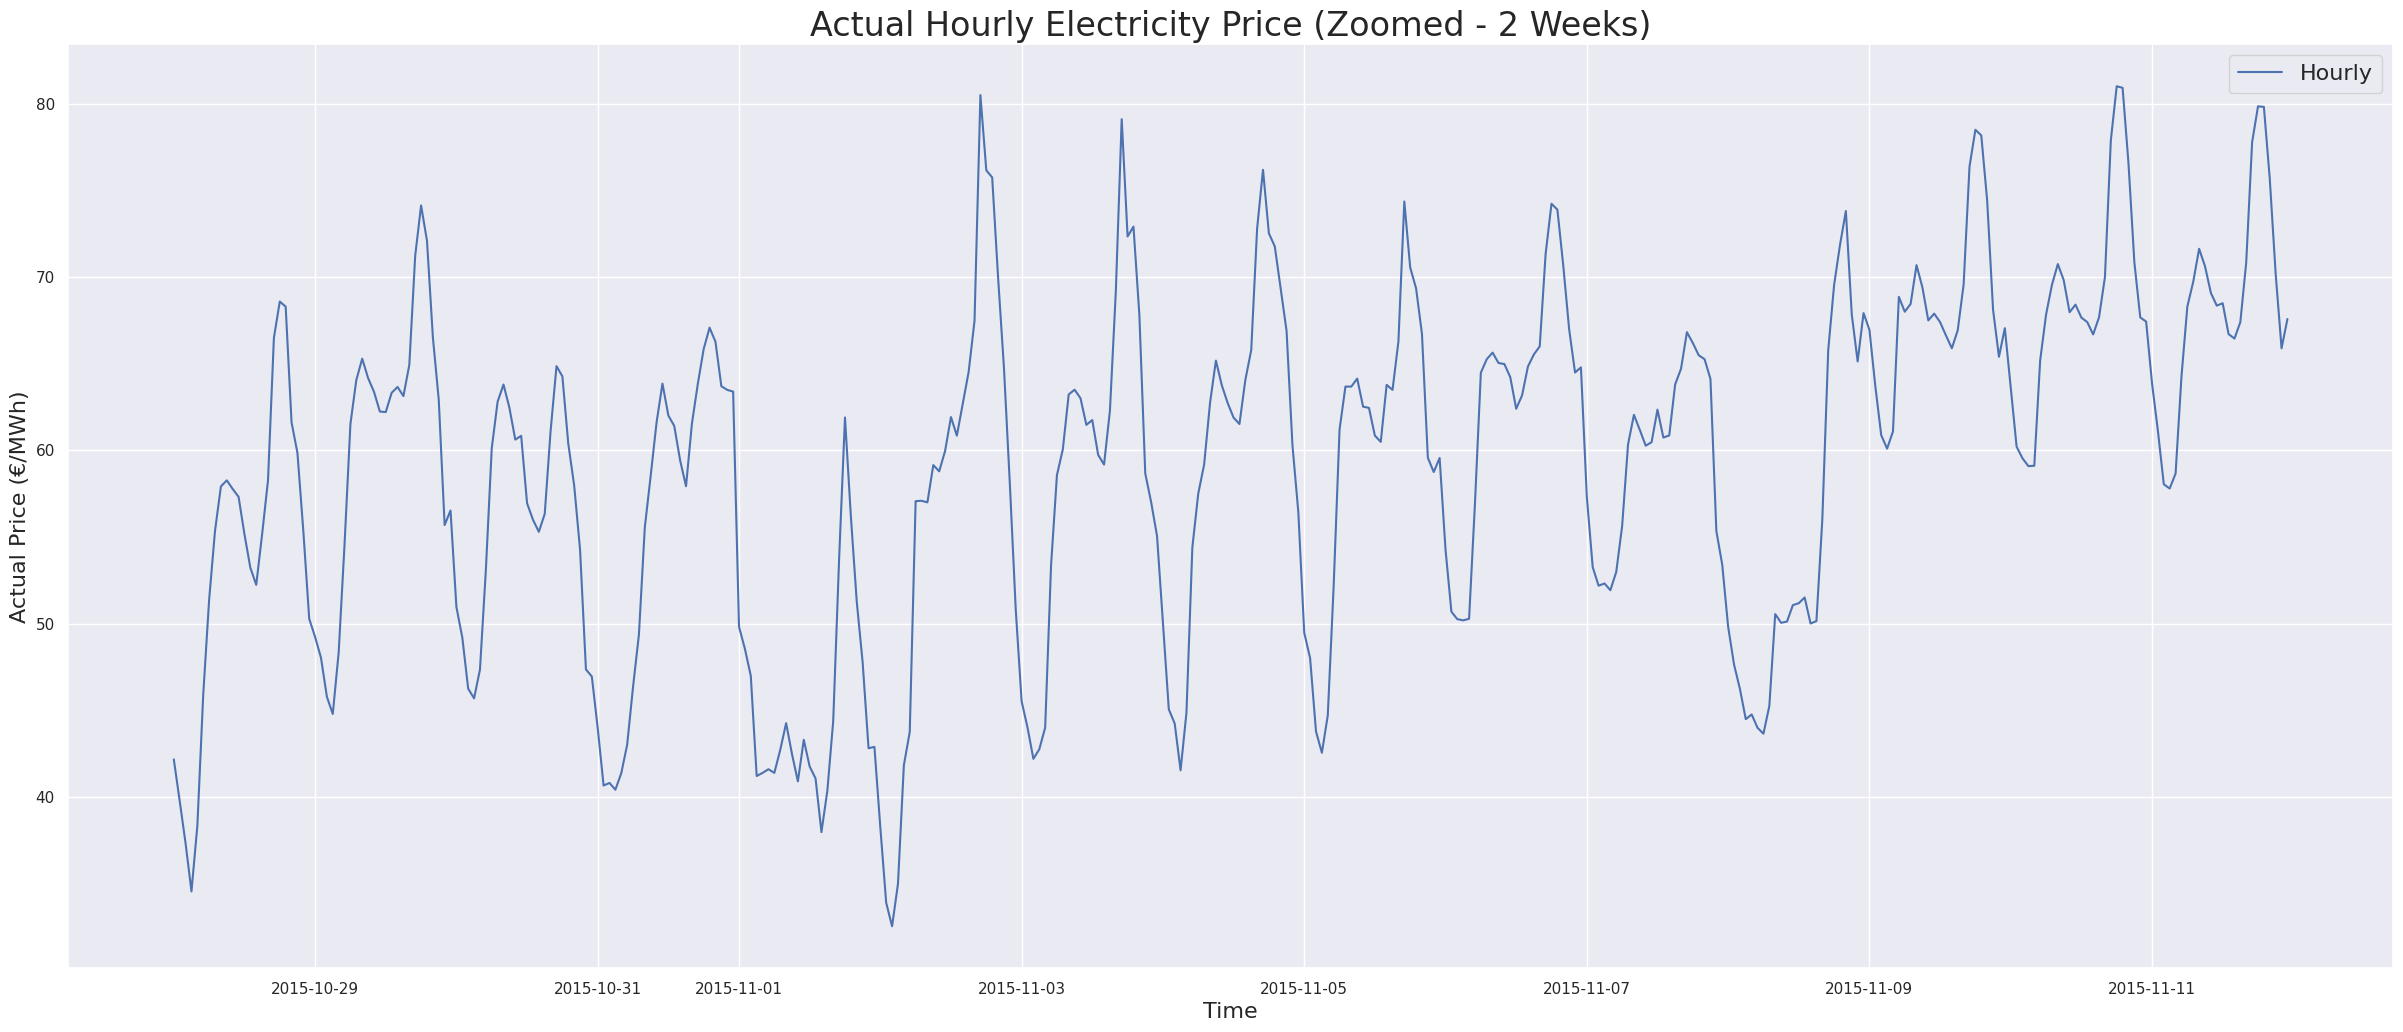

In [148]:
# Plot the actual electricity price at a daily/weekly scale

ax = plot_series(df_complete, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 300, end=1 + 24 * 315,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

In [ ]:
## Change to day of week --> weekday function

We find several patterns and periodicities, including:
-  Weekly seasonality, as the electricity price tends to be higher during business days and lower during weekends and especially during sundays.
- Intradyay pattern, as the price is higher during the day and lower during the night.
- Pattern within the business hours, as in some cases the electricity price drops for a few hours, which is probably due to the Spanish "siesta

Later on, we will make sure that we will generate features which contain these kinds of information.

### 2.1.3 Price Volatility

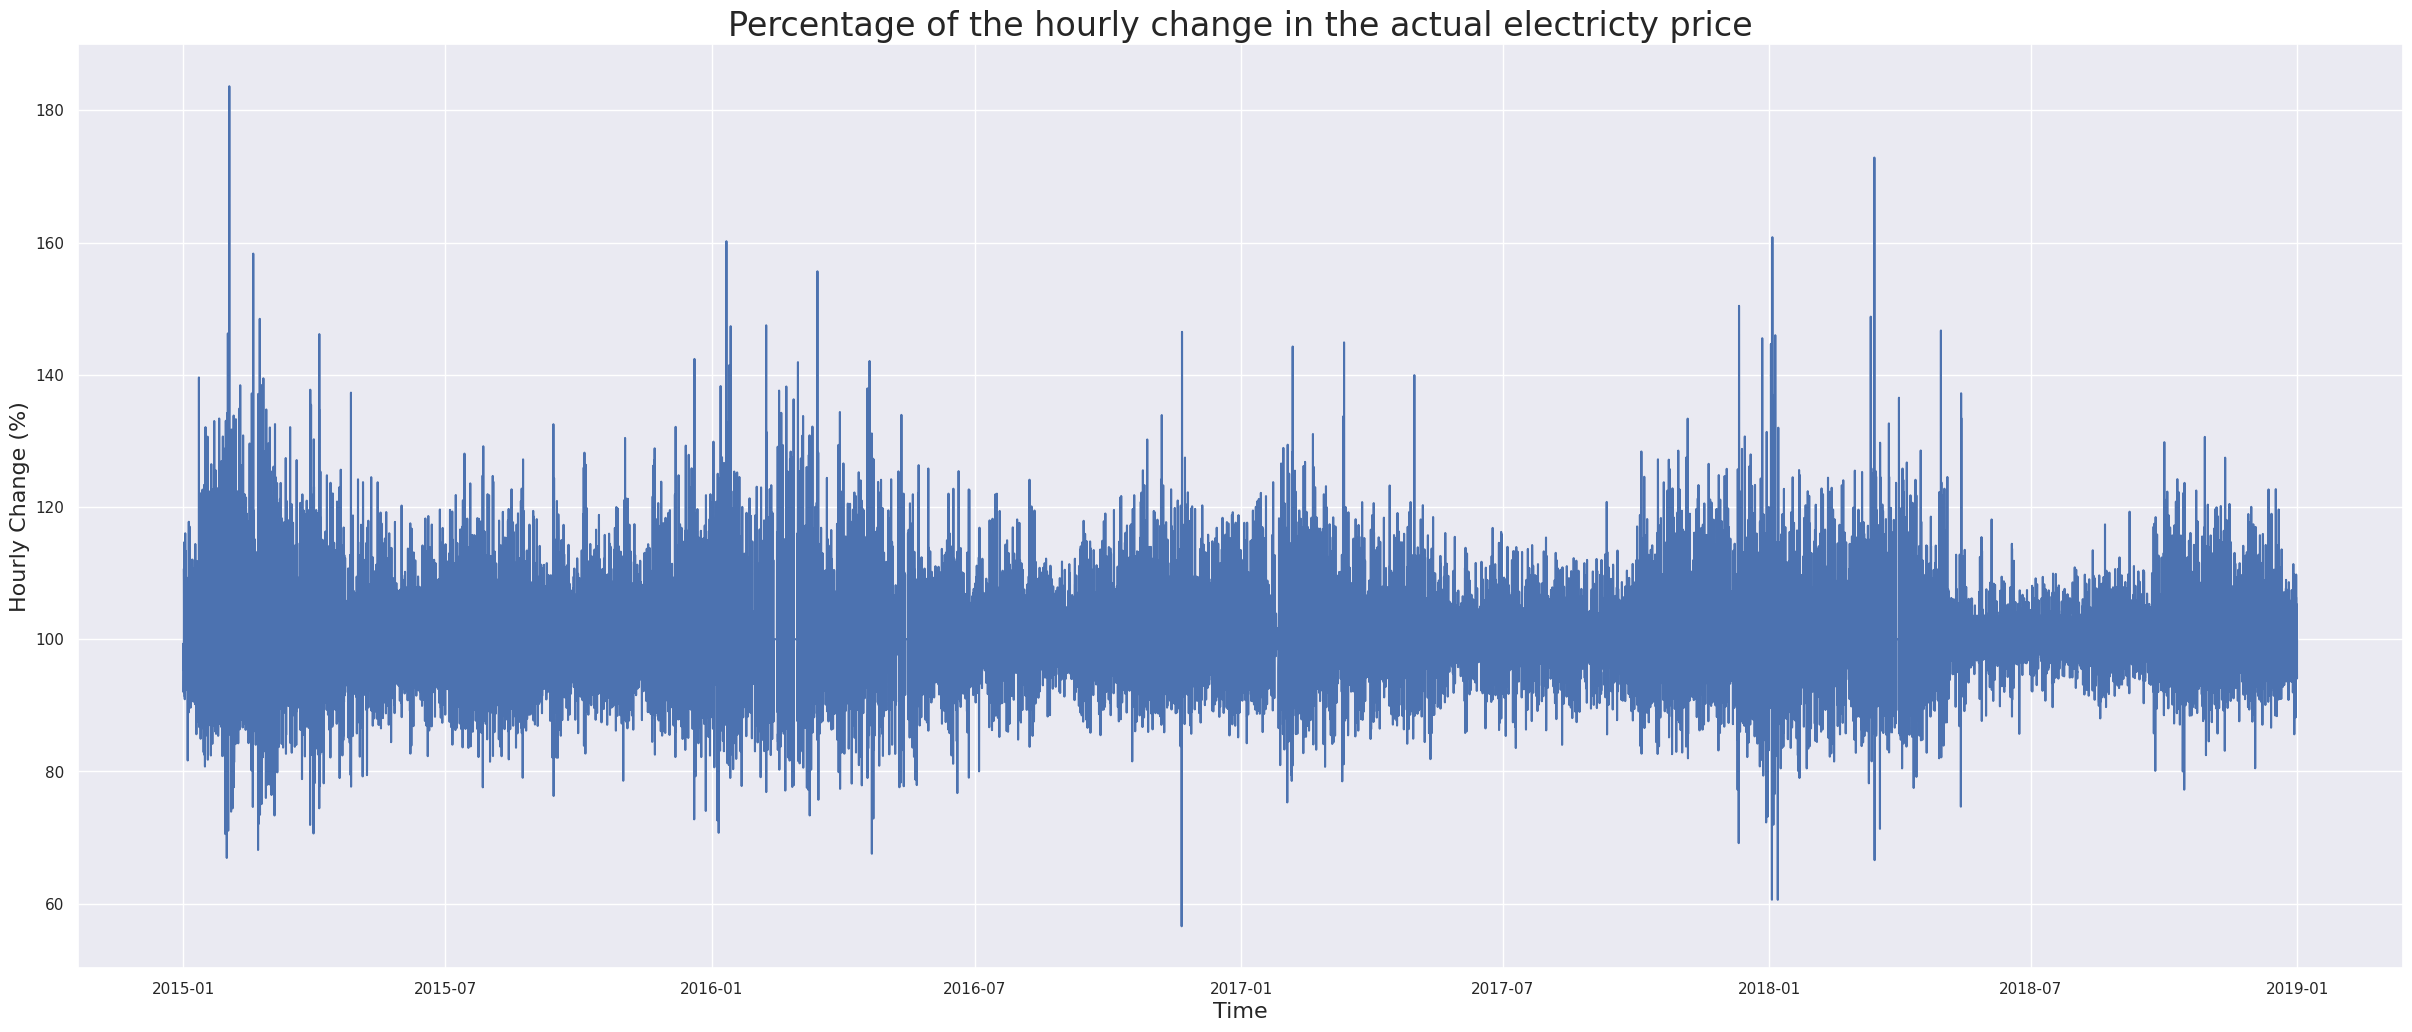

In [149]:
# Plot the percentage of the hourly change in the actual electricity price

change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)',
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

The graph above indicates that change in actual price from hour to hour is in most of the cases between -/+25%. However, there are also very few outliers which show that the price drops by 50% or increases b 0ver 100%. Similar to volatility patterns in financial markets, high levels of volatility are followed by high levels of volatility and vice versa --> GARCH?

### 2.1.4 Price Distribution

<Axes: xlabel='price actual', ylabel='Count'>

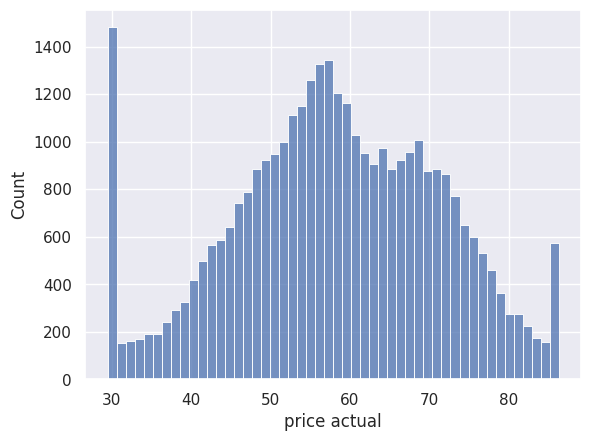

In [150]:
# Review istribution of target variable
sns.histplot(df_complete,x='price actual')

### 2.1.5 Price by Season

In [153]:
# Figure showing Price per total load
fig = px.scatter(df_complete,x='total load actual',
                 y='price actual',
                 facet_col='season',
                 opacity=0.1,
                 title='Price Per KW Hour Compaired To Total Energy Genereated Per Season')
                 #animation_frame=df.index.year)

# Figure customizations
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='darkslateblue')),
                  selector=dict(mode='markers'))

## 2.3 Daily/Monthly Price Behavior

### 2.2.1 Average Price per Hour

<Axes: xlabel='hour', ylabel='price actual'>

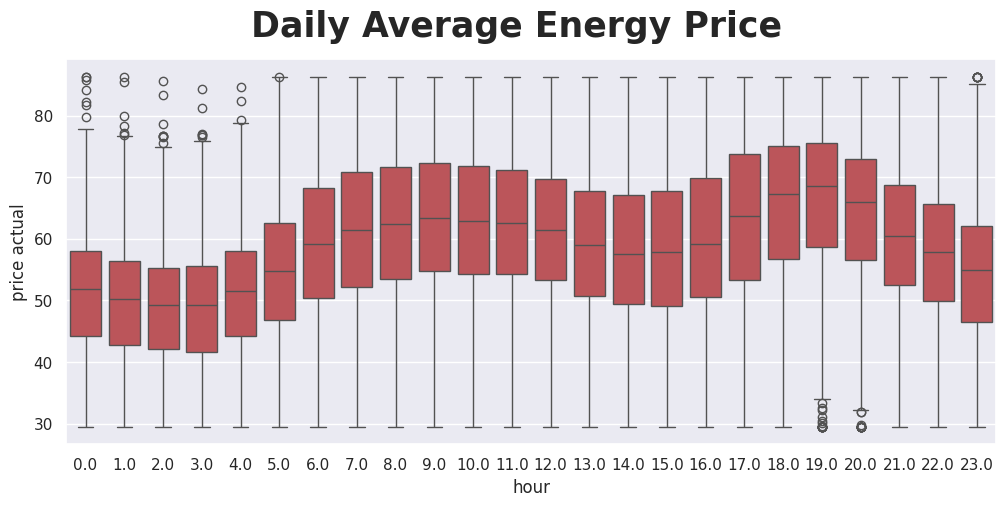

In [162]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
f.suptitle('Daily Average Energy Price', weight='bold', fontsize=25)
sns.boxplot(data=df_complete, x='hour', y= "price actual", color='#cc444b')

### 2.2.2. Hourly Energy Production

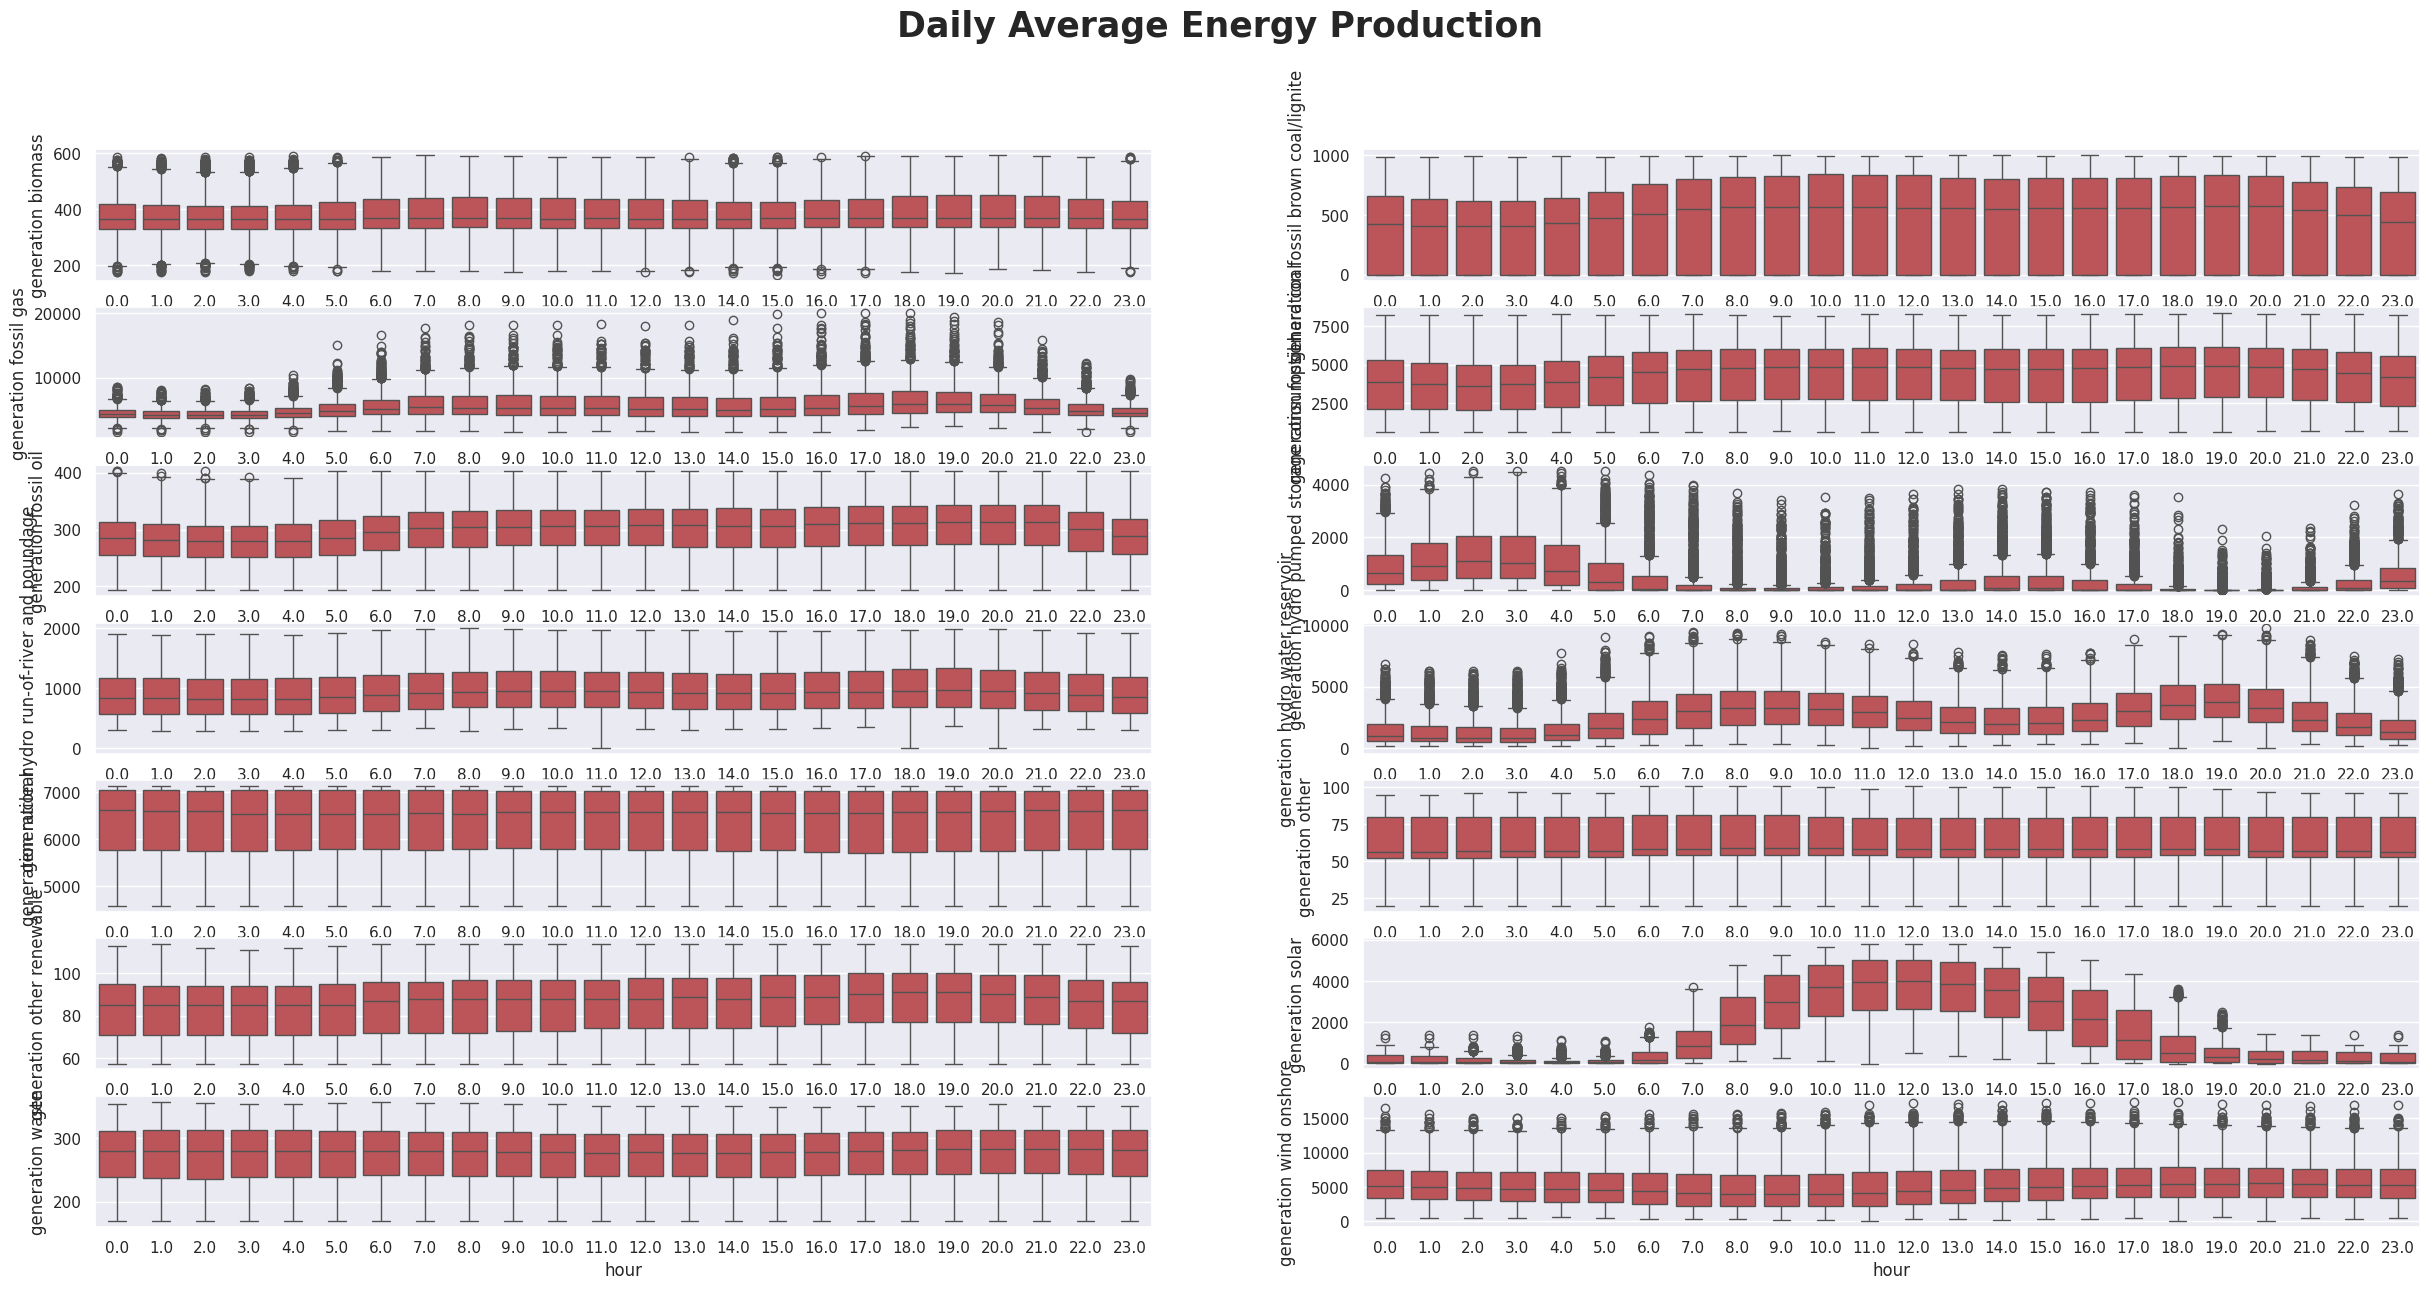

In [163]:
columns = df_complete.columns[0:14]

f, axes = plt.subplots(nrows=7, ncols=2, figsize=(30, 14))
f.suptitle('Daily Average Energy Production', weight='bold', fontsize=25)


for i, col in enumerate(columns):
    sns.boxplot(data=df_complete, x='hour', y=col, ax=axes.flatten()[i], color='#cc444b')

### 2.2.3 Monthly Average Energy Production

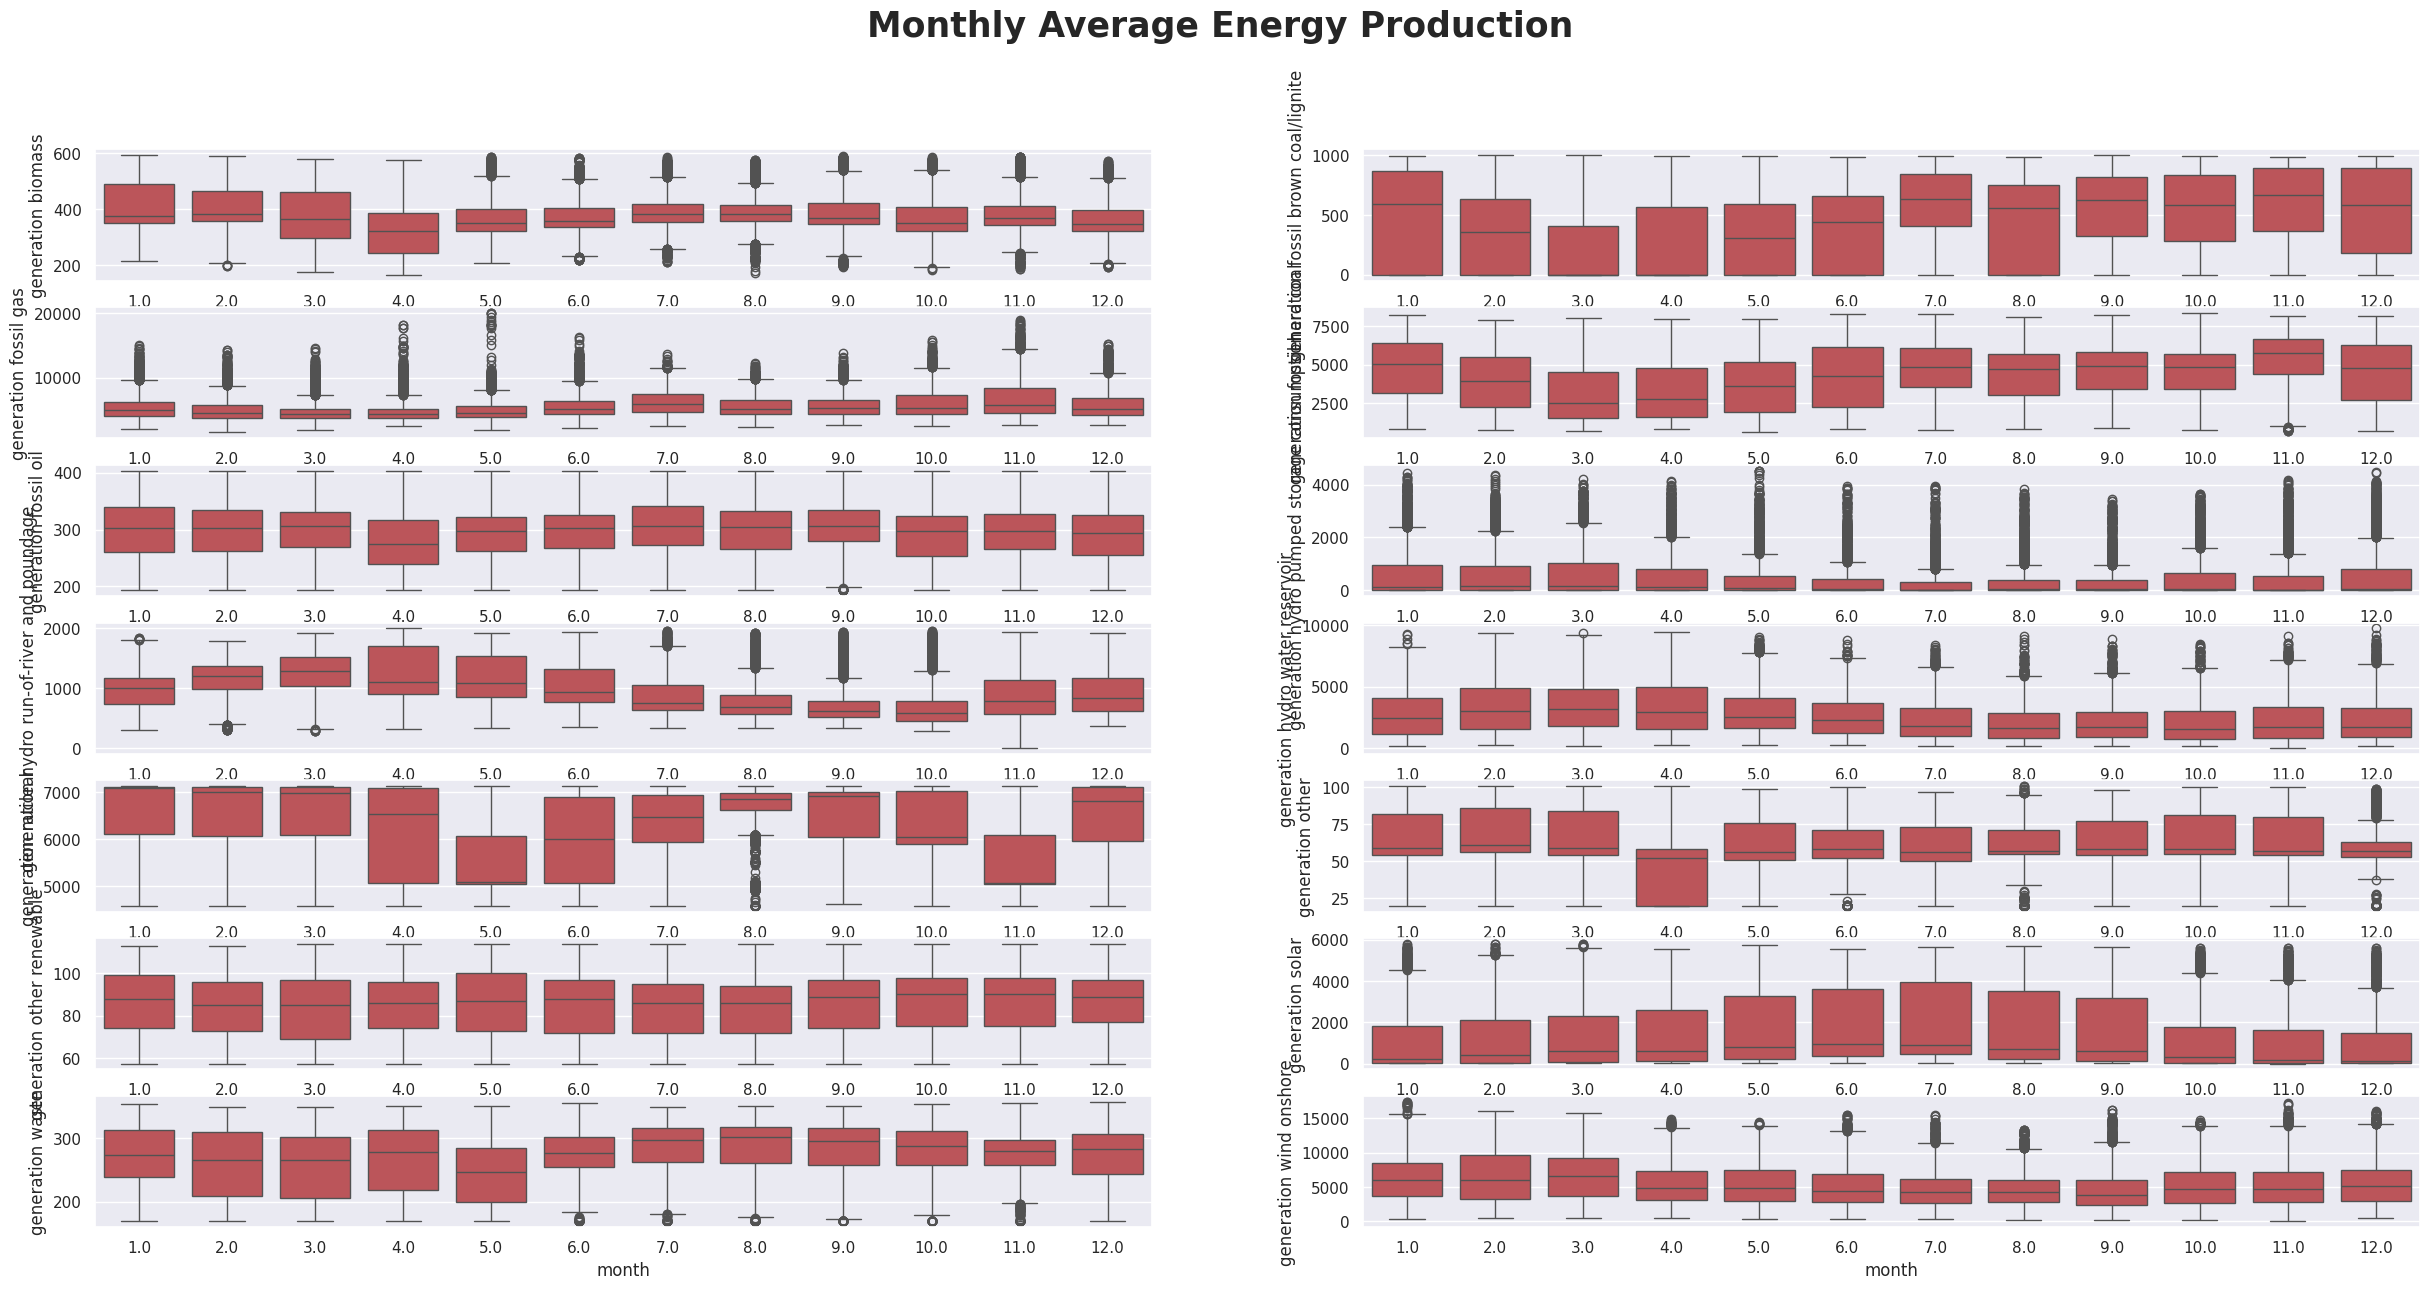

In [164]:
f, axes = plt.subplots(nrows=7, ncols=2, figsize=(30, 14))
f.suptitle('Monthly Average Energy Production', weight='bold', fontsize=25)


for i, col in enumerate(columns):
    sns.boxplot(data=df_complete, x='month', y=col, ax=axes.flatten()[i], color='#cc444b')

## 2.4 Time Series Analysis

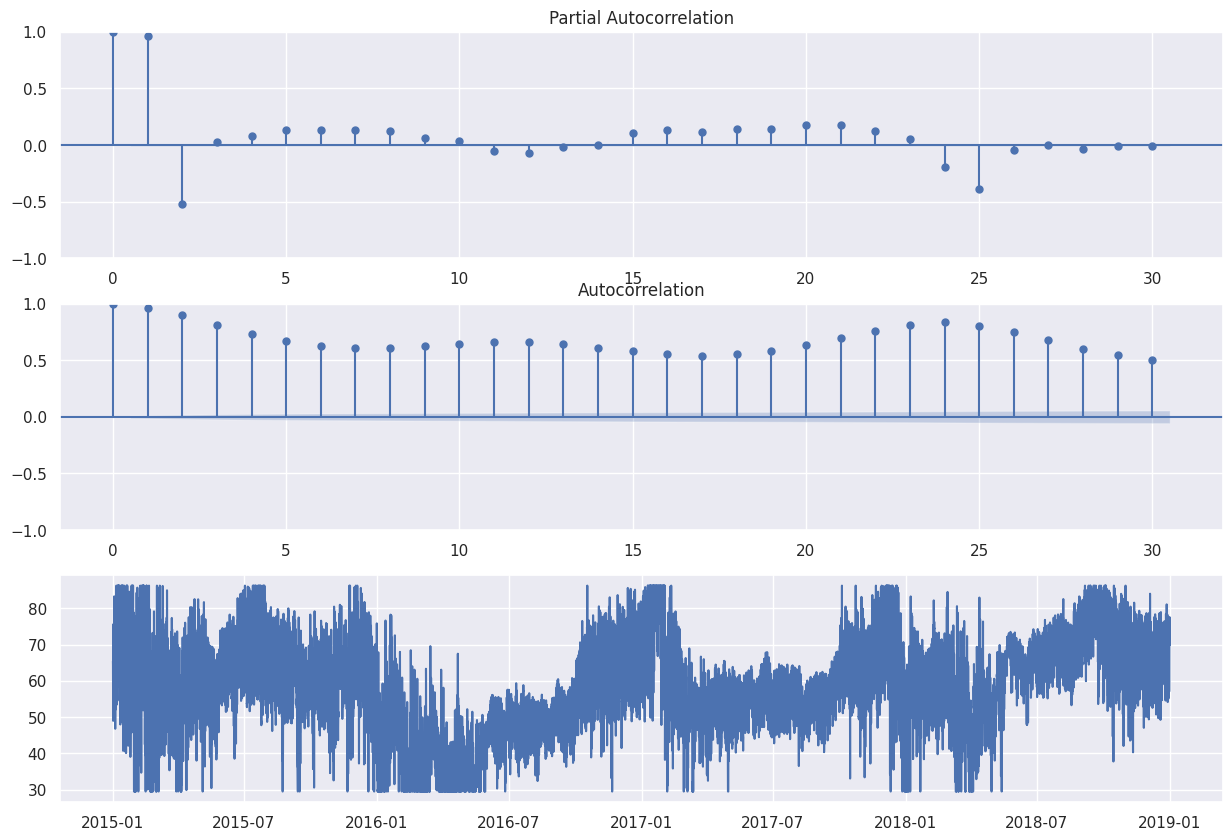

In [177]:
y = df_energy.iloc[:,-2] # target varaible

nlags = 30 # play with this parameter
fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(y, lags = nlags, method="ols", ax=ax[0])
plot_acf(y, lags = nlags, ax=ax[1])
ax[2] = plt.plot(y)
plt.show()

**Observation:** Data is could be stationary but hard to determine. Definetly not White Noise due to ACF and PACF > 0

In [178]:
import statsmodels as sm
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs

# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

adf_test = sm.tsa.stattools.adfuller(y,maxlag=10)
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


# Tests
s = 4 # since we are dealing with quarterly data
d = ndiffs(y, alpha = 0.01, test='adf')  # regular differences?
D = nsdiffs(y, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF test for the original series
Statistic Value: -19.8255861855677
p-value: 0.0
Regular differences:  0
Seasonal differences: 0


**Observations:** ADF Test confirms that Data is stationary, and we do not need to take any seasonal or non-seasonal difference in order to make this data stationary (for now)

Ljung-Box: Statistic value 547759.6868987749 p-value 0.0
Shapido: Statistic value 0.9876882433891296 p-value 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.

<ipython-input-185-ce047eb74e80>:24: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




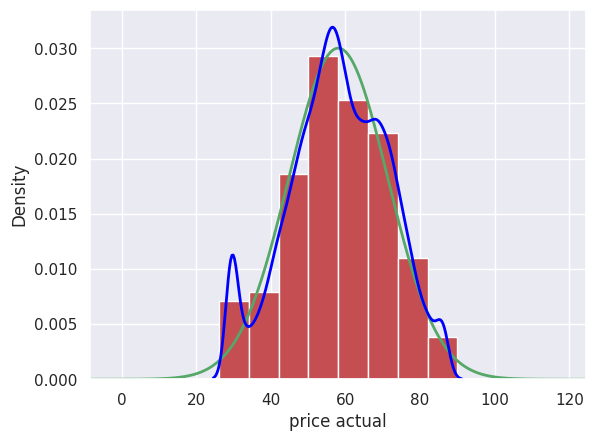

In [185]:
# Confirm Auto Corrrelation and Distribution of Varibale
# Box test
import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(y, lags=[36])

print("Ljung-Box: Statistic value", box_test.iloc[0,0], "p-value", box_test.iloc[0,1])

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalit residuos test

saphiro = shapiro(y)
print("Shapido: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"


mu = np.mean(y)
sigma = np.std(y)
x = np.linspace(mu -5*sigma, mu +5*sigma, 1000)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(y,density=True, range = (mean - 3*std, mean + 3*std), color = "r")
ax = sns.distplot(y, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 5*std, mean + 5*std)

plt.show()

We use the Shaprio Test to confirm whether the dataset is normally distirbuted.Since the p-value is 0 and thus below the 0.05 mark, we reject the Null-Hypothesis and can find that the **data does not follow a normal distribution**

We run the box test to confirm that the data is correlated (ACF, PCAF =! 0). Since the p-value is smaller than 0.05, we reject the null-hypothesis (ACF, PCAF = 0). The **data is uncorrelated**.

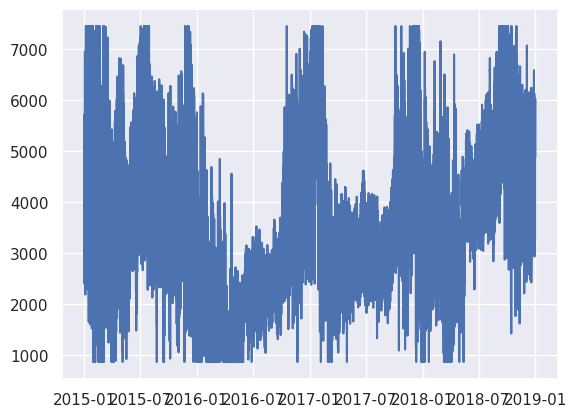

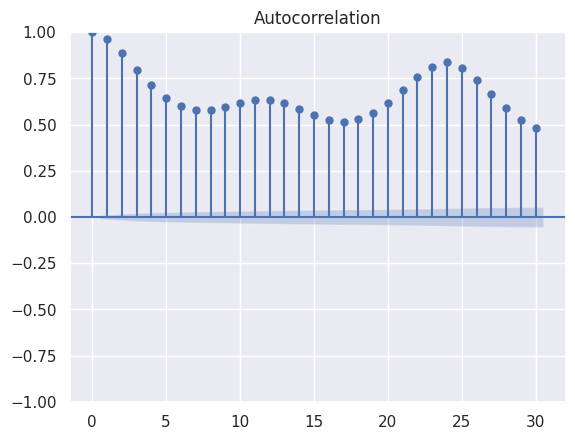

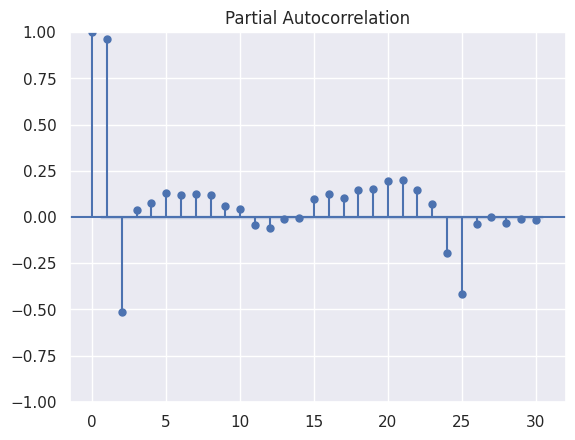

In [188]:
# Review Variance
plt.plot(y**2) #meaning variance
plt.show()
plot_acf(y**2,lags=nlags)
plt.show()
plot_pacf(y**2,lags=nlags,method="ols")
plt.show()

In [189]:
box_test2 = sm.stats.acorr_ljungbox(y**2, lags=[20])
print("Ljung-Box for the squares")
box_test2

Ljung-Box for the squares


,lb_stat,lb_pvalue
20,293544.222506,0.0


**Findings:** The box test tests for correlation, in this case the correlation of the variance. Since the p-value is  0 , we reject the Null-Hypothesis and can confirm that the **variance is correlated** --> ACF and PCAF of Variance =! 0 --> We can model the variance!